In [1]:
%matplotlib inline

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle
import tensorflow as tf
import numpy as np 
import PhyAct as pha

In [3]:
def taylor_nn(prev_layer, weights, phyweights, unkweights, biases, inx_phy, inx_unk, com_type1, com_type2, act_type, 
              num_of_layers, expansion_order, itid, name ='U'):
    
    """Apply a NN to input from previous later

    Arguments:
        prev_layer      -- input from previous NN
        weights         -- dictionary of weights
        biases          -- dictionary of biases (uniform(-1,1) distribution, normal(0,1) distrubution, none--zeros)
        act_type        -- dictionary of activation functions (sigmoid, relu, elu, or none): user option 
        num_of_layers   -- number of weight matrices or layers: user option 
        expansion_order -- dictionary of Taylor expansion order: user option 

    Returns:
        output of network for input from previous layer
    """
    
    for i in np.arange(num_of_layers):
        
        #Compressor One###
        if com_type1['com1%s%d' % (name,i + 1)] == 'sigmoid':
            prev_layer = tf.sigmoid(prev_layer)
        elif com_type1['com1%s%d' % (name,i + 1)] == 'relu':
            prev_layer = tf.nn.relu(prev_layer)
        elif com_type1['com1%s%d' % (name,i + 1)] == 'none':
            prev_layer = prev_layer
        ###################################################################################################################################
        
        #Compressor Two###
        if com_type2['com2%s%d' % (name,i + 1)] == 'sigmoid':
            prev_layer = tf.sigmoid(prev_layer)
        elif com_type2['com2%s%d' % (name,i + 1)] == 'none':
            prev_layer = prev_layer
        ###################################################################################################################################
        
        #save raw input###
        input_raw = prev_layer
        raw_input_shape = input_raw.shape
        ###################################################################################################################################
        
        #The expaned input via Taylor expansion is denoted by input_epd###
        input_epd = input_raw
        ###################################################################################################################################
        
        io = int(raw_input_shape[0])
        Id = np.arange(io)
        ###################################################################################################################################
        
         #Nolinear mapping through Taylor expansion###
        for v in range(expansion_order['E%s%d' % (name, i +  1)]):
            for j in range(raw_input_shape[0]):
                for q in range(raw_input_shape[1]):
                    x_temp = tf.multiply(input_raw[j,q], input_epd[Id[j]:(Id[raw_input_shape[0]-1]+1),q])
        
                    if j == 0 and v == 0 and i == 0 and itid == 0:
                        x_temp = x_temp
                    else:
                        x_temp = tf.expand_dims(x_temp,1)

                    if q == 0:
                        tem_temp = x_temp
                    else:
                        tem_temp = tf.concat((tem_temp,x_temp),1)
                Id[j] = input_epd.shape[0] 
                input_epd = tf.concat((input_epd,tem_temp),0)
        ###################################################################################################################################

        ###################################################################################################################################
 
        #Compute T.NN output###
        pre_bias   = tf.multiply(biases['b%s%d' % (name,i + 1)], inx_unk['b%s%d' % (name,i + 1)])  
            
        pre_weight_A = phyweights['W%s%d' % (name,i + 1)]    
        pre_weight_B = tf.multiply(weights['W%s%d' % (name,i + 1)], unkweights['W%s%d' % (name,i + 1)])
        prev_layer_A = tf.matmul(pre_weight_A, input_epd)
        prev_layer_B = tf.matmul(pre_weight_B, input_epd) + pre_bias
        
        if act_type['act%s%d' % (name,i + 1)]    == 'sigmoid':
            prev_layer_B = pha.pysigmoid(prev_layer_B, inx_unk['b%s%d' % (name,i + 1)])
        elif act_type['act%s%d' % (name,i + 1)]  == 'relu':
            prev_layer_B = pha.pyrelu(prev_layer_B, inx_unk['bk%s%d' % (name,i + 1)])
        elif act_type ['act%s%d' % (name,i + 1)] == 'elu':
            prev_layer_B = pha.pyelu(prev_layer_B, inx_unk['b%s%d' % (name,i + 1)])
        elif act_type['act%s%d' % (name,i + 1)] == 'none':
            prev_layer_B = prev_layer_B
            
        prev_layer = prev_layer_A + prev_layer_B        
        #################################################################################################################################     
    
    #Returen final output of created DeepTaylor###
    return prev_layer

In [4]:
##Model Parameters#########################################################################################################
params = {}
input_dim = 6; 
out1 = 6;

params['data_name'] = 'Pendulum'
params['seed'] = 10000000
params['uncheckable_dist_weights'] = ['tn','tn']
params['uncheckable_output_size'] = [input_dim,out1,6]
params['uncheckable_epd'] = np.array([3,0])
params['uncheckable_act'] = ['elu','none']
params['uncheckable_com_type1'] = ['none','none']
params['uncheckable_com_type2'] = ['none','none']
params['uncheckable_dist_biases'] = ['normal','normal']
params['uncheckable_num_of_layers'] = len(np.array([0,0])) 
###########################################################################################################################

In [5]:
##embed physical knowledge#################################################################################################
#known model parameters
T = 0.005
########################


##layer 1##========================================================================================
a_input_dim = 209;  #number of nodes after expansion

Phy_lay1_A = np.zeros((out1,a_input_dim), dtype=np.float64)  #knowledge matrix
Phy_lay1_B = np.zeros((out1,a_input_dim), dtype=np.float64)  #learning parameter indication matrix

phyBias_lay1_A = np.zeros((out1,1), dtype=np.float64)  #knowledge bias
phyBias_lay1_B = np.ones((out1,1), dtype=np.float64)   #learning parameter indication bias

Phy_lay1_A[0][0] = 1;
Phy_lay1_A[0][3] = T;
Phy_lay1_A[1][1] = 1;
Phy_lay1_A[1][4] = T;
Phy_lay1_A[2][2] = 1;
Phy_lay1_A[2][5] = T;
Phy_lay1_A[3][3] = 1;
Phy_lay1_A[4][4] = 1;
Phy_lay1_A[5][5] = 1;

Phy_lay1_B[3][0]    = 1;
Phy_lay1_B[3][1]    = 1;
Phy_lay1_B[3][6]    = 1;
Phy_lay1_B[3][7]    = 1;
Phy_lay1_B[3][12]    = 1;
Phy_lay1_B[3][27]    = 1;
Phy_lay1_B[3][28]    = 1;
Phy_lay1_B[3][33]    = 1;
Phy_lay1_B[3][48]    = 1;
Phy_lay1_B[3][83]    = 1;
Phy_lay1_B[3][84]    = 1;
Phy_lay1_B[3][89]    = 1;
Phy_lay1_B[3][104]    = 1;
Phy_lay1_B[3][139]    = 1;
Phy_lay1_B[4][0]    = 1;
Phy_lay1_B[4][1]    = 1;
Phy_lay1_B[4][2]    = 1;
Phy_lay1_B[4][6]    = 1;
Phy_lay1_B[4][7]    = 1;
Phy_lay1_B[4][8]    = 1;
Phy_lay1_B[4][12]    = 1;
Phy_lay1_B[4][13]    = 1;
Phy_lay1_B[4][17]    = 1;
Phy_lay1_B[4][27]    = 1;
Phy_lay1_B[4][28]    = 1;
Phy_lay1_B[4][29]    = 1;
Phy_lay1_B[4][33]    = 1;
Phy_lay1_B[4][34]    = 1;
Phy_lay1_B[4][38]    = 1;
Phy_lay1_B[4][48]    = 1;
Phy_lay1_B[4][49]    = 1;
Phy_lay1_B[4][53]    = 1;
Phy_lay1_B[4][63]    = 1;
Phy_lay1_B[4][83]    = 1;
Phy_lay1_B[4][84]    = 1;
Phy_lay1_B[4][85]    = 1;
Phy_lay1_B[4][89]    = 1;
Phy_lay1_B[4][90]    = 1;
Phy_lay1_B[4][94]    = 1;
Phy_lay1_B[4][104]    = 1;
Phy_lay1_B[4][105]    = 1;
Phy_lay1_B[4][109]    = 1;
Phy_lay1_B[4][119]    = 1;
Phy_lay1_B[4][139]    = 1;
Phy_lay1_B[4][140]    = 1;
Phy_lay1_B[4][144]    = 1;
Phy_lay1_B[4][154]    = 1;
Phy_lay1_B[4][174]    = 1;
Phy_lay1_B[5][1]    = 1;
Phy_lay1_B[5][2]    = 1;
Phy_lay1_B[5][12]    = 1;
Phy_lay1_B[5][13]    = 1;
Phy_lay1_B[5][17]    = 1;
Phy_lay1_B[5][48]    = 1;
Phy_lay1_B[5][49]    = 1;
Phy_lay1_B[5][53]    = 1;
Phy_lay1_B[5][63]    = 1;
Phy_lay1_B[5][139]    = 1;
Phy_lay1_B[5][140]    = 1;
Phy_lay1_B[5][144]    = 1;
Phy_lay1_B[5][154]    = 1;
Phy_lay1_B[5][174]    = 1;

phyBias_lay1_B[0:3] = 0
###########===========================================================================================================

##Layer2##============================================================================================================
Phy_lay2_A = np.zeros((6,out1), dtype=np.float64)
Phy_lay2_B = np.zeros((6,out1), dtype=np.float64)
phyBias_lay2_A = np.zeros((6,1), dtype=np.float64)
phyBias_lay2_B = np.ones((6,1), dtype=np.float64)

Phy_lay2_A[0][0] = 1;
Phy_lay2_A[1][1] = 1;
Phy_lay2_A[2][2] = 1;
Phy_lay2_A[3][3] = 1;
Phy_lay2_A[4][4] = 1;
Phy_lay2_A[5][5] = 1;

phyBias_lay2_B[0:3] = 0
###########

params['uncheckable_phyweightsA'] = [Phy_lay1_A, Phy_lay2_A]
params['uncheckable_phyweightsB'] = [Phy_lay1_B, Phy_lay2_B]
params['uncheckable_phybiasesA'] = [phyBias_lay1_A, phyBias_lay2_A]
params['uncheckable_phybiasesB'] = [phyBias_lay1_B, phyBias_lay2_B]
###########################################################################################################################


In [6]:
##Load Weights, bias, activation and expansion order#####################################################################################################
WU = dict()
bU = dict()
act_typeU = dict()
com_typeU1 = dict() 
com_typeU2 = dict()
expansion_orderU = dict()
phyweightsU = dict() 
unkweightsU = dict()
inx_phyU    = dict()
inx_unkU    = dict()

for j in range(params['uncheckable_num_of_layers']):
    WU['WU%d' % (j + 1)] = np.matrix(np.loadtxt("../oscillaor_elu_full_degree_dn/exp_WU%d.csv" % (j+1), delimiter=',', dtype=np.float64)) 
    bU['bU%d' % (j + 1)] = np.transpose(np.matrix(np.loadtxt("../oscillaor_elu_full_degree_dn/exp_bU%d.csv" % (j+1), delimiter=',', dtype=np.float64)))    
    act_typeU['actU%d' % (j + 1)] = params['uncheckable_act'][j]
    expansion_orderU['EU%d' % (j + 1)] = params['uncheckable_epd'][j]
    com_typeU1['com1U%d' % (j + 1)] = params['uncheckable_com_type1'][j]
    com_typeU2['com2U%d' % (j + 1)] = params['uncheckable_com_type2'][j]
    phyweightsU['WU%d' % (j + 1)] = params['uncheckable_phyweightsA'][j]
    unkweightsU['WU%d' % (j + 1)] = params['uncheckable_phyweightsB'][j]
    inx_phyU['bU%d' % (j + 1)] = params['uncheckable_phybiasesA'][j]
    inx_unkU['bU%d' % (j + 1)] = params['uncheckable_phybiasesB'][j]
############################################################################################################################

In [7]:
##load data############################################################################################################
Xtest = np.matrix(np.loadtxt("../post/testdata1/OOscillatorsns_test_x.csv",delimiter=',', dtype=np.float64));
Ytest = np.matrix(np.loadtxt("../post/testdata1/OOscillatorsns_test_y.csv",delimiter=',', dtype=np.float64));
#######################################################################################################################

In [8]:
##Data from trained model##############################################################################################
ti = 500
tLen = 150                 

#x = np.transpose(np.matrix([-2.44104942223000,2.33808811031000,2.21384943235233,-0.00855097600220,-0.00482805432882,0.00122297222615]))

x = np.transpose(Xtest[ti,:])



for u in range(tLen):

    
    y = taylor_nn(prev_layer=x, weights=WU, phyweights=phyweightsU, unkweights=unkweightsU, biases=bU, inx_phy=inx_phyU,
                  inx_unk=inx_unkU, com_type1=com_typeU1, com_type2=com_typeU2, act_type=act_typeU, num_of_layers=params['uncheckable_num_of_layers'], 
                  expansion_order=expansion_orderU, itid = u, name='U')
    
    
    yrecord = y.eval(session=tf.compat.v1.Session())
    
    x = y
    

    if u == 0:
        Y_train = yrecord
    else:
        Y_train = np.concatenate((Y_train,yrecord),axis= 1)

    

  ######################################################################################################################      

In [9]:
##trure data###########################################################################################################
Ycom = np.transpose(Ytest[(ti):(ti+tLen),:])
#######################################################################################################################

In [10]:
##process data##########################################################################################################
t = np.arange(tLen)
t = np.reshape(t,(1,tLen))

Y1_train = np.reshape(Y_train[0,:],(1,tLen))
Y1_com = Ycom[0,:].flatten()
Y2_train = np.reshape(Y_train[1,:],(1,tLen))
Y2_com = Ycom[1,:].flatten()
Y3_train = np.reshape(Y_train[2,:],(1,tLen))
Y3_com = Ycom[2,:].flatten()
Y4_train = np.reshape(Y_train[3,:],(1,tLen))
Y4_com = Ycom[3,:].flatten()
Y5_train = np.reshape(Y_train[4,:],(1,tLen))
Y5_com = Ycom[4,:].flatten()
Y6_train = np.reshape(Y_train[5,:],(1,tLen))
Y6_com = Ycom[5,:].flatten()

t = t.flatten()
Y1_train = (np.asarray(Y1_train)).flatten()
Y1_com = (np.asarray(Y1_com)).flatten()
Y2_train = (np.asarray(Y2_train)).flatten()
Y2_com = (np.asarray(Y2_com)).flatten()
Y3_train = (np.asarray(Y3_train)).flatten()
Y3_com = (np.asarray(Y3_com)).flatten()
Y4_train = (np.asarray(Y4_train)).flatten()
Y4_com = (np.asarray(Y4_com)).flatten()
Y5_train = (np.asarray(Y5_train)).flatten()
Y5_com = (np.asarray(Y5_com)).flatten()
Y6_train = (np.asarray(Y6_train)).flatten()
Y6_com = (np.asarray(Y6_com)).flatten()

########################################################################################################################################### 

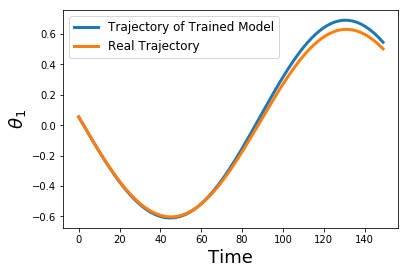

In [11]:
plt.plot(t,Y1_train,Y1_com, linewidth=3)
plt.xlabel("Time", fontsize=18)
plt.ylabel(r'$\theta_1$', fontsize=18)
#plt.title("(b)", fontsize=18)
plt.gca().legend(('Trajectory of Trained Model','Real Trajectory'), fontsize=12)
plt.show()

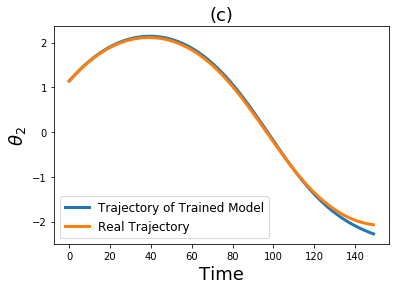

In [12]:
plt.plot(t,Y2_train,Y2_com, linewidth=3)
plt.xlabel("Time", fontsize=18)
plt.ylabel(r'$\theta_2$', fontsize=18)
plt.title("(c)", fontsize=18)
plt.gca().legend(('Trajectory of Trained Model','Real Trajectory'), fontsize=12)
plt.show()

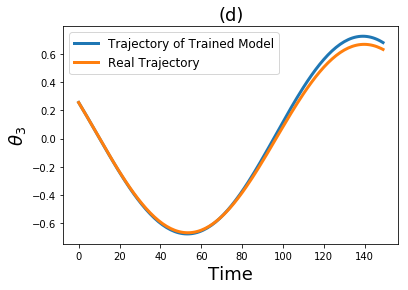

In [13]:
plt.plot(t,Y3_train,Y3_com, linewidth=3)
plt.xlabel("Time", fontsize=18)
plt.ylabel(r'$\theta_3$', fontsize=18)
plt.title("(d)", fontsize=18)
plt.gca().legend(('Trajectory of Trained Model','Real Trajectory'), fontsize=12)
plt.show()

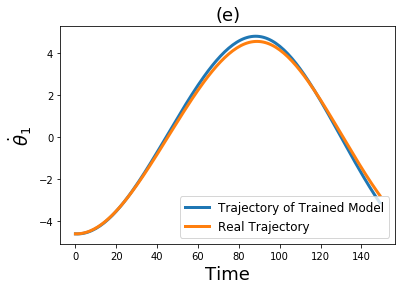

In [14]:
plt.plot(t,Y4_train,Y4_com, linewidth=3)
plt.xlabel("Time", fontsize=18)
plt.ylabel(r'$\dot{\theta}_1$', fontsize=18)
plt.title("(e)", fontsize=18)
plt.gca().legend(('Trajectory of Trained Model','Real Trajectory'), fontsize=12)
plt.show()

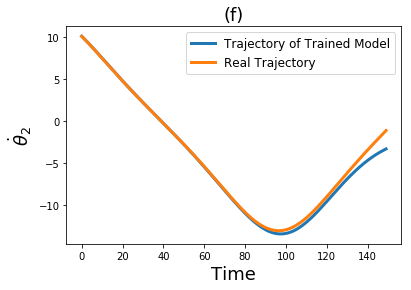

In [15]:
plt.plot(t,Y5_train,Y5_com, linewidth=3)
plt.xlabel("Time", fontsize=18)
plt.ylabel(r'$\dot{\theta}_2$', fontsize=18)
plt.title("(f)", fontsize=18)
plt.gca().legend(('Trajectory of Trained Model','Real Trajectory'), fontsize=12)
plt.show()

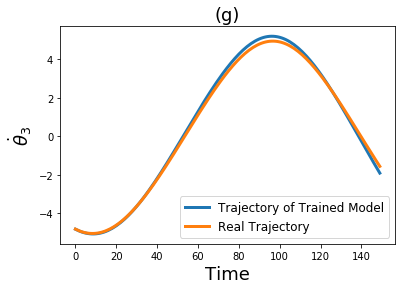

In [16]:
plt.plot(t,Y6_train,Y6_com, linewidth=3)
plt.xlabel("Time", fontsize=18)
plt.ylabel(r'$\dot{\theta}_3$', fontsize=18)
plt.title("(g)", fontsize=18)
plt.gca().legend(('Trajectory of Trained Model','Real Trajectory'), fontsize=12)
plt.show()

In [17]:
test_error =  (np.mean(np.square(Y1_train - Y1_com)) + np.mean(np.square(Y2_train - Y2_com)) + np.mean(np.square(Y3_train - Y3_com)) + np.mean(np.square(Y4_train - Y4_com)) + np.mean(np.square(Y5_train - Y5_com)) + np.mean(np.square(Y6_train - Y6_com)))/6
    
print(test_error)  

0.06486147458620344


In [18]:
import csv
f1 = open('../post/vvax1.csv', 'w')
f2 = open('../post/vvax2.csv', 'w')
f3 = open('../post/vvax3.csv', 'w')
f4 = open('../post/vvav1.csv', 'w')
f5 = open('../post/vvav2.csv', 'w')
f6 = open('../post/vvav3.csv', 'w')

writer1 = csv.writer(f1)
writer2 = csv.writer(f2)
writer3 = csv.writer(f3)
writer4 = csv.writer(f4)
writer5 = csv.writer(f5)
writer6 = csv.writer(f6)

writer1.writerow(Y1_train)
writer2.writerow(Y2_train)
writer3.writerow(Y3_train)
writer4.writerow(Y4_train)
writer5.writerow(Y5_train)
writer6.writerow(Y6_train)

f1.close()
f2.close()
f3.close()
f4.close()
f5.close()
f6.close()

In [20]:
##process data##########################################################################################################
t = np.arange(tLen)
t = np.reshape(t,(1,tLen))

Y1_train = np.reshape(Y_train[0,:],(1,tLen))
Y1_com = Ycom[0,:].flatten()
Y2_train = np.reshape(Y_train[1,:],(1,tLen))
Y2_com = Ycom[1,:].flatten()



t = t.flatten()
Y1_train = (np.asarray(Y1_train)).flatten()
Y1_com = (np.asarray(Y1_com)).flatten()
Y2_train = (np.asarray(Y2_train)).flatten()
Y2_com = (np.asarray(Y2_com)).flatten()
########################################################################################################################################### 

In [ ]:
figure, axis = plt.subplots(2)
  
# For Sine Function
axis[0].plot(t,Y1_train,Y1_com)
axis[0].set_ylabel("angular")
axis[0].legend(('trained','real'))

axis[1].plot(t,Y2_train,Y2_com)
axis[1].set_ylabel("angular velocity")
axis[1].legend(('trained','real'))





plt.xlabel("Time")
plt.subplots_adjust(left=-0.5, bottom=-1.5, right=1, top=0)
plt.show()